In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from skimage import io,transform
from PIL import Image 
import os
# from torch.utils.data import Dataset
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, utils,models
device = torch.device("cuda:0:" if torch.cuda.is_available() else "cpu")

In [2]:
directory_name ="./pins-face-recognition/"

# Explore the dataset

In [3]:
# list all directory of celebrity 
all_directory_path = [x[0] for x in os.walk(directory_name)][1:]

In [4]:
#vocabulary creation
#create necessary vocabulary for later use
dirs = sorted(os.listdir(directory_name))
name_to_classid = {d:i for i,d in enumerate(dirs)}
classid_to_name = {v:k for k,v in name_to_classid.items()}
num_classes = len(name_to_classid)
print("number of classes: "+str(num_classes))

number of classes: 100


In [5]:
# read all directories
img_paths = {c:[directory + "/" + img for img in sorted(os.listdir(directory_name+directory))] 
             for directory,c in name_to_classid.items()}
# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list
# map to integers
path_to_id = {v:k for k,v in enumerate(all_images_path)}
id_to_path = {v:k for k,v in path_to_id.items()}

In [6]:
#get total images
def totalImageCount(directory):
    total_images=0
    for i in range(len(all_directory_path)):
        total_images += len(list(os.walk(all_directory_path[i]))[0][2])
    return total_images
print("total directory is ",len(all_directory_path))
print("total images are " ,totalImageCount(all_directory_path))


total directory is  100
total images are  10770


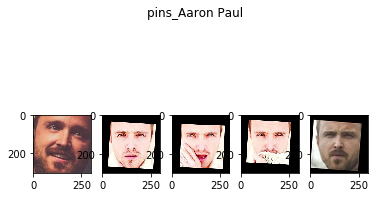

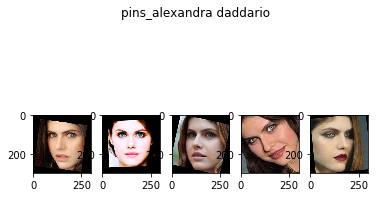

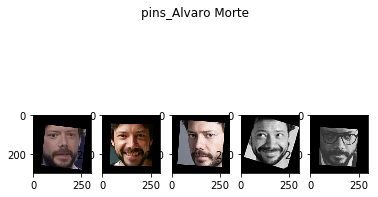

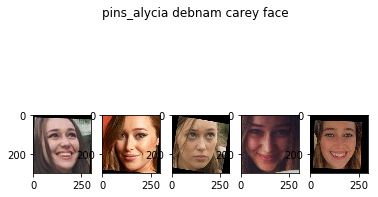

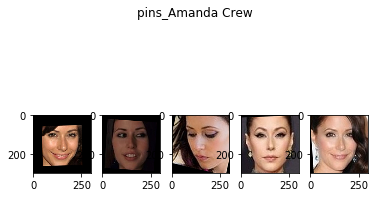

In [7]:
#show sample image in all celebrity directory
def show_sample_images(n_samples=5,directory_name=directory_name):
    directory=os.listdir(directory_name)
    for each in directory[:n_samples]:
        plt.figure()
        currentFolder = directory_name+'/' + each
        for i, file in enumerate(os.listdir(currentFolder)[0:n_samples]):
            fullpath = currentFolder+"/"+ file
            i=i+1
            img=io.imread(os.path.join(fullpath))
            plt.subplot(1,n_samples,i)
            plt.imshow(img)
            plt.suptitle(each)
show_sample_images()

pins_Morgan Freeman images


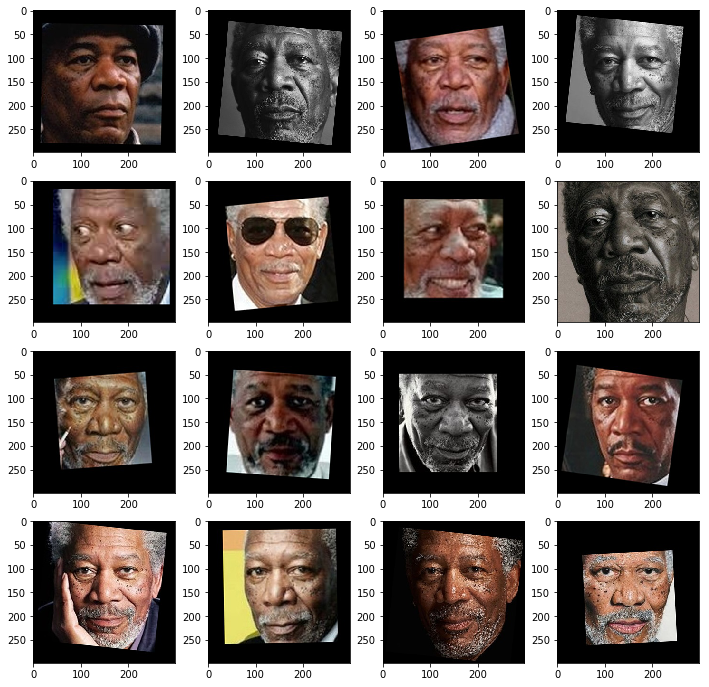

In [8]:
#show sample images from single celebrity directory
def show_sample_from_directory(directory_index):
    i=0
    print(classid_to_name[directory_index],"images")
    _ ,fig = plt.subplots(4, 4, figsize=(12,12))
    dir_images=img_paths[directory_index]
    
    fig = fig.flatten()
    for f in fig:
        image_path=os.path.join(directory_name+"/"+str(dir_images[i]))
        f.imshow(io.imread(image_path))
        i=i+1
show_sample_from_directory(40)

# Load dataset from generated csv 

In [9]:
dataset = pd.read_csv("dataset.csv")

In [10]:
dataset.head()

,images,class
0,./pins-face-recognition/pins_Aaron Paul/Aaron ...,0
1,./pins-face-recognition/pins_Aaron Paul/Aaron ...,0
2,./pins-face-recognition/pins_Aaron Paul/Aaron ...,0
3,./pins-face-recognition/pins_Aaron Paul/Aaron ...,0
4,./pins-face-recognition/pins_Aaron Paul/Aaron ...,0


# Dev train split 

In [355]:
#split dataset

In [11]:
from sklearn.model_selection import train_test_split
dataset_train,dataset_validation =train_test_split(dataset,test_size=0.2)

In [12]:
#check the distribution of classes 
dataset_validation.groupby("class").count().head(13)

,images
class,
0,18
1,19
2,29
3,17
4,9
5,14
6,13
7,29
8,25


In [13]:
print("number of training set ",len(dataset_train))
print("number of development set",len(dataset_validation))

number of training set  8616
number of development set 2154


In [14]:
#necessary vocab(for developer understanding who is a  yo yo ganjini )
classid_to_name

{0: 'pins_Aaron Paul',
 1: 'pins_Alvaro Morte',
 2: 'pins_Amanda Crew',
 3: 'pins_Amaury Nolasco',
 4: 'pins_Anna Gunn',
 5: 'pins_Benedict Cumberbatch',
 6: 'pins_Betsy Brandt',
 7: 'pins_Brenton Thwaites',
 8: 'pins_Brit Marling',
 9: 'pins_Bryan Cranston',
 10: 'pins_Caity Lotz',
 11: 'pins_Cameron Monaghan',
 12: 'pins_Chance Perdomo',
 13: 'pins_Chris Evans',
 14: 'pins_Chris Pratt',
 15: 'pins_Cobie Smulders',
 16: 'pins_Danielle Panabaker',
 17: 'pins_Dave Franco',
 18: 'pins_Dominic Purcell',
 19: 'pins_Dwayne Johnson',
 20: 'pins_Emilia Clarke',
 21: 'pins_Emily Bett Rickards',
 22: 'pins_Emma Stone',
 23: 'pins_Gwyneth Paltrow',
 24: 'pins_Henry Cavil',
 25: 'pins_Jason Momoa',
 26: 'pins_Jeremy Renner',
 27: 'pins_Jesse Eisenberg',
 28: 'pins_Jim Parsons',
 29: 'pins_Jon Bernthal',
 30: 'pins_Josh Radnor',
 31: 'pins_Kit Harington',
 32: 'pins_Krysten Ritter',
 33: 'pins_Kumail Nanjiani',
 34: 'pins_Maisie Williams',
 35: 'pins_Mark Ruffalo',
 36: 'pins_Martin Starr',
 37: '

# Data preprocessing

# Custom dataloader  class

In [15]:
class PinterestDataset(Dataset):
    '''
    Dataframe : pandas dataframe which contains celebrity class and corresponding image path
    key note:
    we have to choose positive and negative sample for each targets for dev and training set
    '''
    def __init__(self,dataframe,transform):
        self.data = dataframe
        self.transform = transform
#         self.train = isTrain
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #get image name
        image_name= str(self.data.iloc[idx,0])
        #get image array
        anchor_image = io.imread(image_name)
        #get class of the image
        class_value = self.data.iloc[idx,1]
        #do positive sampling
        #get all data relative to the corresponding image class
        get_all_positive = self.data[self.data["class"]==class_value]
        #remove the particular image data from queried data
        get_all_positive = get_all_positive[get_all_positive["images"]!=image_name]
        #choose random data from that filtered dataset
        positive_frame =get_all_positive.sample(n=1)
        positive_image = io.imread(str(positive_frame.iloc[0,0]))
        #choose negative data by taking random sampling except that particular class
        get_all_negative = self.data[self.data["class"]!=class_value]
        negative_frame = get_all_negative.sample(n=1)
        negative_image = io.imread(str(negative_frame.iloc[0,0]))
        
#         return_array = [anchor_image,positive_image,negative_image]
        
        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)
       # return torch.tensor([anchor_image,positive_image,negative_image])
        return {
            "anchor":anchor_image,
            "positive_image":positive_image,
            "negative_image":negative_image
        }
    
    def __len__(self):
        return len(self.data)


# Transformation custom loader class

In [16]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        
        image = sample
        
        h, w = image.shape[:2]
#         print(h,w)
#         if isinstance(self.output_size, int):
#             if h > w:
#                 new_h, new_w = self.output_size * h / w, self.output_size
#             else:
#                 new_h, new_w = self.output_size, self.output_size * w / h
#         else:
#             new_h, new_w = self.output_size
        new_h = self.output_size
        new_w = self.output_size
#         new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w,3))
        return img
        

In [17]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        image = sample
#         print(type(torch.from_numpy(image)))
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
#         print(image.shape)
     
        image = image.transpose((2, 0, 1))
        
        return image

In [18]:
class Normalize(object):
    def __init__(self,mean,std):
        self.mean=mean
        self.std=std
    def __call__(self,sample):
        image = sample
        normalized=  (image -self.mean) / self.std
        return normalized

In [19]:
transformed_dataset_train = PinterestDataset(dataset_train,
                                        transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
                                                          ]))
transformed_dataset_validation = PinterestDataset(dataset_validation,
                                        transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
                                                          ]))


In [570]:
# for i in range(8000):
#     a=transformed_dataset_train[i]
    

In [20]:
# plt.imshow(a["anchor"][0])

In [22]:
train_dataloader=DataLoader(transformed_dataset_train,batch_size=32,shuffle=True)
validation_dataloader=DataLoader(transformed_dataset_validation,batch_size=32,shuffle=True)

In [23]:

def im_convert(tensor):
 
#     image = tensor.numpy()
    image = tensor.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image
# plt.imshow((sample["image"]))

In [24]:
i= 898
sample_anchor= im_convert(transformed_dataset_train[i]["anchor"])
sample_pos= im_convert(transformed_dataset_train[i]["positive_image"])
sample_neg= im_convert(transformed_dataset_train[i]["negative_image"])

/home/vinodarjun/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/vinodarjun/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [25]:
transformed_dataset_train[i]["anchor"].shape

(3, 224, 224)

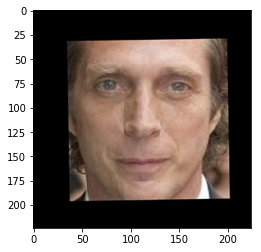

In [26]:
plt.imshow(sample_anchor)

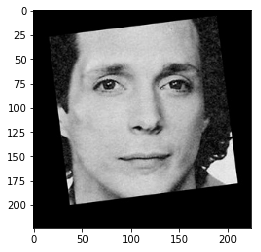

In [27]:
plt.imshow(sample_pos)

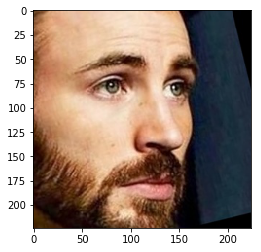

In [28]:
plt.imshow(sample_neg)

In [629]:
# for i,j in enumerate(train_dataloader):
#     print(j["anchor"].shape)
#     break


# visualize sampling batch

In [790]:
test=DataLoader(transformed_dataset_train,batch_size=5,shuffle=True)
test_batch =iter(test).next()

/home/vinodarjun/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/vinodarjun/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [792]:
def img_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image
# plt.imshow((sample["image"]))
def visualize_samples(dictionary):
#     print(n_samples)
    for key,data in enumerate(dictionary):
        plt.figure()
        plt.suptitle(data)
        for i in range((dictionary[data][:5].shape[0])):
            j=i
            i=i+1
            plt.subplot(1,5,i)            
            plt.imshow(img_convert(dictionary[data][j]))    

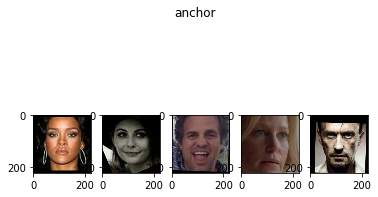

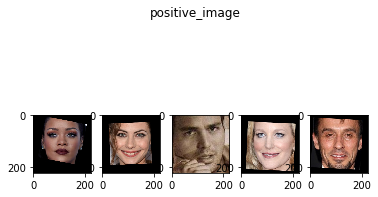

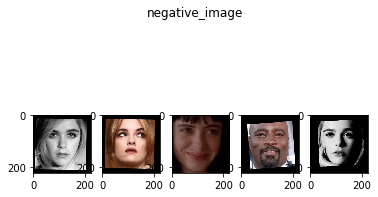

In [793]:
visualize_samples(test_batch)

In [29]:

resnet = models.resnet18(pretrained=True)

In [845]:
# resnet= resnet.double()

In [30]:

for param in resnet.parameters():
    param.requires_grad = False

n_inputs = resnet.fc.in_features

last_layer = nn.Linear(n_inputs, 128)
resnet.fc = last_layer
resnet.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Model creation

In [31]:

class EmbeddingNet(nn.Module):
    def __init__(self,pretrained_net):
        super(EmbeddingNet, self).__init__()
        self.resnet = pretrained_net

    def forward(self, x):
        output = self.resnet(x)
        return output

    def get_embedding(self, x):
        return self.forward(x)


In [32]:

class TripletNet(nn.Module):
    '''
    input
    embedding net : ConvNet which takes torch.tensor input
     run parallel convnet for each batch
    '''
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [38]:
embedding_net = EmbeddingNet(resnet)
model = TripletNet(embedding_net)

# Creating triplet loss class

In [39]:
class TripletLoss(nn.Module):
    """
    Input:
        margin : (float) 
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  
        distance_negative = (anchor - negative).pow(2).sum(1) 
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [40]:
margin = 0.5
loss_fn = TripletLoss(margin)
lr = 1e-3


In [56]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)


In [ ]:
# epochs = 5
# running_loss_history = []
# val_running_loss_history=[]
# losses=[]
# total_loss=0
# for e in range(epochs):
#     running_loss=0.0
#     val_running_loss=0.0
#     for i,batched_data in enumerate(train_dataloader):
#         print(i)
#         input_anchor= batched_data["anchor"].to(device)
#         input_positive = batched_data["positive_image"].to(device)
#         input_negative = batched_data["negative_image"].to(device)
#         optimizer.zero_grad()
#         outputs = model(input_anchor.float(),input_positive.float(),input_negative.float())
#         if type(outputs) not in (tuple, list):
#             outputs = (outputs,)
#         loss_inputs = outputs
#         loss_outputs = loss_fn(*loss_inputs)
#         loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
#         losses.append(loss.item())
#         total_loss += loss.item()
#         loss.backward()
#         optimizer.step()
# #         loss = loss_fn(input_anchor.float(),input_positive.float(),input_negative.float())
# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()
#         running_loss+=loss.item()
#         print(loss.item())
#     else:
#         pass
# #         with torch.no_grad():
# #             for i,batched_val in enumerate(validation_dataloader):
# #                 val_input_anchor = batched_val["anchor"].to(device)
# #                 val_input_positive = batched_val["positive_image"].to(device)
# #                 val_input_negative = batched_val["negative_image"].to(device)
               
# #                 val_outputs = model(val_input_anchor.float(),val_input_positive.float(),val_input_negative.float())
# #                 val_loss = loss_fn(val_input_anchor.float(),val_input_positive.float(),val_input_negative.float())
# #                 val_running_loss+=val_loss.item()
# # #         print(val_loss.item())
    
# #   epoch_loss
# #     epoch_loss = running_loss/len(train_dataloader.dataset)
  
# #     running_loss_history.append(epoch_loss)
    
# #     val_epoch_loss = val_running_loss/len(validation_dataloader.dataset)
# #     val_running_loss_history.append(val_epoch_loss)
# #     print('epoch :', (e+1))
# #     print('training loss: {:.4f}'.format(epoch_loss))
# #     print('validation loss: {:.4f}'.format(val_epoch_loss))

In [65]:
def train_one_epoch(train_loader, model, loss_fn, optimizer,printer):

    model.train()
    losses = []
    total_loss = 0
    for batch_idx, batched_data in enumerate(train_loader):
        
        input_anchor= batched_data["anchor"].to(device).float()
        input_positive = batched_data["positive_image"].to(device).float()
        input_negative = batched_data["negative_image"].to(device).float()
        optimizer.zero_grad()
        outputs = model(input_anchor,input_positive,input_negative)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)
        loss_inputs = outputs
        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
        if batch_idx % printer == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(batched_data["anchor"][0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            
            print(message)
            losses = []
    total_loss /= (batch_idx + 1)
    return total_loss




In [45]:
# train_one_epoch(train_dataloader,model,loss_fn,optimizer,5)

In [66]:
def test_one_epoch(val_loader, model, loss_fn):
    with torch.no_grad():
        model.eval()
        val_loss = 0
        for batch_idx,val_batched_data in enumerate(val_loader):
            print(batch_idx)
            val_anchor=val_batched_data["anchor"].to(device).float()
            val_positive = val_batched_data["positive_image"].to(device).float()
            val_negative =val_batched_data["negative_image"].to(device).float()
            outputs = model(val_anchor,val_positive,val_negative)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

           

    return val_loss

In [52]:
# test_one_epoch(validation_dataloader,model,loss_fn)

In [67]:
def train(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, printer,start_epoch=0):
   
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss = train_one_epoch(train_loader, model, loss_fn, optimizer, printer)

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        
        val_loss = test_one_epoch(val_loader, model, loss_fn)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
       
        print(message)

In [68]:
train(train_dataloader,validation_dataloader,model,loss_fn,optimizer,scheduler,5,2)

Train: [0/8616 (0%)]	Loss: 1.547204
Train: [6/8616 (1%)]	Loss: 1.405508
Train: [12/8616 (1%)]	Loss: 1.653635
Train: [18/8616 (2%)]	Loss: 2.326966
Train: [24/8616 (3%)]	Loss: 1.873624
Train: [30/8616 (4%)]	Loss: 2.526957
Train: [36/8616 (4%)]	Loss: 1.096068
Train: [42/8616 (5%)]	Loss: 2.115788
Train: [48/8616 (6%)]	Loss: 1.824526
Train: [54/8616 (7%)]	Loss: 2.698798
Train: [60/8616 (7%)]	Loss: 1.939041
Train: [66/8616 (8%)]	Loss: 2.264478
Train: [72/8616 (9%)]	Loss: 1.672473
Train: [78/8616 (10%)]	Loss: 2.075358
Train: [84/8616 (10%)]	Loss: 2.000801
Train: [90/8616 (11%)]	Loss: 1.145919
Train: [96/8616 (12%)]	Loss: 1.917538
Train: [102/8616 (13%)]	Loss: 2.116508
Train: [108/8616 (13%)]	Loss: 1.378701
Train: [114/8616 (14%)]	Loss: 1.661520
Train: [120/8616 (15%)]	Loss: 1.679503
Train: [126/8616 (16%)]	Loss: 1.440800
Train: [132/8616 (16%)]	Loss: 2.080002
Train: [138/8616 (17%)]	Loss: 1.685525
Train: [144/8616 (18%)]	Loss: 2.231960
Train: [150/8616 (19%)]	Loss: 3.982327
Train: [156/8616 (

Train: [420/8616 (52%)]	Loss: 0.973937
Train: [426/8616 (53%)]	Loss: 1.649272
Train: [432/8616 (53%)]	Loss: 2.350240
Train: [438/8616 (54%)]	Loss: 1.174237
Train: [444/8616 (55%)]	Loss: 1.524023
Train: [450/8616 (56%)]	Loss: 1.607277
Train: [456/8616 (56%)]	Loss: 2.126316
Train: [462/8616 (57%)]	Loss: 2.130825
Train: [468/8616 (58%)]	Loss: 1.266047
Train: [474/8616 (59%)]	Loss: 1.720631
Train: [480/8616 (59%)]	Loss: 0.833431
Train: [486/8616 (60%)]	Loss: 1.550230
Train: [492/8616 (61%)]	Loss: 1.008467
Train: [498/8616 (61%)]	Loss: 1.939206
Train: [504/8616 (62%)]	Loss: 1.394664
Train: [510/8616 (63%)]	Loss: 1.433813
Train: [516/8616 (64%)]	Loss: 1.623413
Train: [522/8616 (64%)]	Loss: 2.222799
Train: [528/8616 (65%)]	Loss: 2.315928
Train: [534/8616 (66%)]	Loss: 2.171789
Train: [540/8616 (67%)]	Loss: 2.052380
Train: [546/8616 (67%)]	Loss: 1.772786
Train: [552/8616 (68%)]	Loss: 1.862031
Train: [558/8616 (69%)]	Loss: 1.844182
Train: [564/8616 (70%)]	Loss: 1.550002
Train: [570/8616 (70%)]	L

50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
Epoch: 3/5. Train set: Average loss: 1.7503
Epoch: 3/5. Validation set: Average loss: 2.1254
Train: [0/8616 (0%)]	Loss: 1.639189
Train: [6/8616 (1%)]	Loss: 1.549010
Train: [12/8616 (1%)]	Loss: 1.722159
Train: [18/8616 (2%)]	Loss: 1.287283
Train: [24/8616 (3%)]	Loss: 1.894206
Train: [30/8616 (4%)]	Loss: 1.726813
Train: [36/8616 (4%)]	Loss: 2.594715
Train: [42/8616 (5%)]	Loss: 2.624355
Train: [48/8616 (6%)]	Loss: 1.615163
Train: [54/8616 (7%)]	Loss: 1.550010
Train: [60/8616 (7%)]	Loss: 1.290639
Train: [66/8616 (8%)]	Loss: 2.080664
Train: [72/8616 (9%)]	Loss: 1.751000
Train: [78/8616 (10%)]	Loss: 1.229204
Train: [84/8616 (10%)]	Loss: 2.417672
Train: [90/8616 (11%)]	Loss: 0.767855
Train: [96/8616 (12%)]	Loss: 1.733558
Train: [102/8616 (13%)]	Loss: 1.528914
Train: [108/8616 (13%)]	Loss: 1.844612
Train: [114/8616 (14%)]	Loss: 1.778503
Train: [120/8616 (15%)]	Loss: 1.548825
Train: [126/8616 (16%)]	Loss: 1.825129
Train: [132/8616 (16%)]	Los

Train: [396/8616 (49%)]	Loss: 1.612408
Train: [402/8616 (50%)]	Loss: 1.367784
Train: [408/8616 (50%)]	Loss: 0.646858
Train: [414/8616 (51%)]	Loss: 1.759579
Train: [420/8616 (52%)]	Loss: 1.487541
Train: [426/8616 (53%)]	Loss: 1.187624
Train: [432/8616 (53%)]	Loss: 1.450712
Train: [438/8616 (54%)]	Loss: 1.115552
Train: [444/8616 (55%)]	Loss: 1.501628
Train: [450/8616 (56%)]	Loss: 2.017514
Train: [456/8616 (56%)]	Loss: 1.272603
Train: [462/8616 (57%)]	Loss: 1.560183
Train: [468/8616 (58%)]	Loss: 1.308693
Train: [474/8616 (59%)]	Loss: 1.395093
Train: [480/8616 (59%)]	Loss: 1.801999
Train: [486/8616 (60%)]	Loss: 2.167289
Train: [492/8616 (61%)]	Loss: 1.399358
Train: [498/8616 (61%)]	Loss: 1.805125
Train: [504/8616 (62%)]	Loss: 1.508209
Train: [510/8616 (63%)]	Loss: 1.113725
Train: [516/8616 (64%)]	Loss: 1.600915
Train: [522/8616 (64%)]	Loss: 2.002708
Train: [528/8616 (65%)]	Loss: 1.415416
Train: [534/8616 (66%)]	Loss: 1.509293
Train: [540/8616 (67%)]	Loss: 1.406577
Train: [546/8616 (67%)]	L

In [69]:
torch.save(model.state_dict(), "saved_model v1.pth")

# Exploring validation

In [71]:
sample_batch =iter(validation_dataloader).next()

/home/vinodarjun/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/vinodarjun/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [76]:
sample_anchor = sample_batch["anchor"].float()
sample_positive = sample_batch["positive_image"].float()
sample_negative = sample_batch["negative_image"].float()

In [79]:
#predict for validation batch
#get embedding for anchor
sample_anchor_emb = model.get_embedding(sample_anchor)

In [81]:
#get embedding for positive 
sample_positive_emb = model.get_embedding(sample_positive)

In [82]:
#get embedding for negative 
sample_negative_emb=model.get_embedding(sample_negative)

In [84]:
from numpy import dot
from numpy.linalg import norm
def cosine_similarity(a,b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

In [101]:
i=31
#distance between anchor and negative
cosine_similarity(sample_anchor_emb[i].detach().numpy(),sample_negative_emb[i].detach().numpy())

0.42773464

In [102]:
#distance between anchor and positive
cosine_similarity(sample_anchor_emb[i].detach().numpy(),sample_positive_emb[i].detach().numpy())

0.7580364

In [105]:
dist_pos=[]
dist_neg =[]
for i in range(31):
    dist_pos.append(cosine_similarity(sample_anchor_emb[i].detach().numpy(),sample_positive_emb[i].detach().numpy()))
    dist_neg.append( cosine_similarity(sample_anchor_emb[i].detach().numpy(),sample_negative_emb[i].detach().numpy()) )
df = pd.DataFrame()
df["dist between positive and anchor"]= dist_pos
df["dist between negative and anchor"]= dist_neg

In [107]:
#single batch validation
df

,dist between positive and anchor,dist between negative and anchor
0,0.681100,0.592357
1,0.568884,0.396118
2,0.750592,0.456726
3,0.716120,0.391386
4,0.656361,0.434727
5,0.729428,0.472287
6,0.761247,0.448386
7,0.742728,0.345019
8,0.597949,0.766601
9,0.687507,0.641161


validation sample Anchor images are


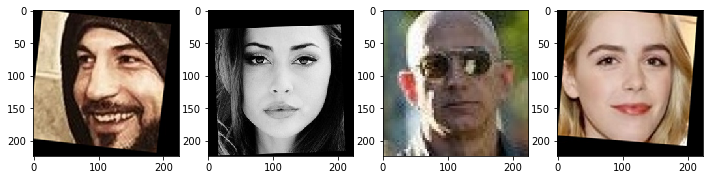

In [171]:

def show_grid(image_array,n_row=1,n_col=4,vector_a=None,vector_b=None):

    i=0
    _ ,fig = plt.subplots(n_row, n_col, figsize=(12,12))
#   print(fig)
    
    fig = fig.flatten()
#   print(fig)
    for f in fig:
#     print(i,f)
        image= image_array[i]
        f.imshow(img_convert(image))
        if vector_a is not None:
            distance = cosine_similarity(vector_a[i].detach().numpy(),vector_b[i].detach().numpy())
            f.title.set_text(str(distance))
        i=i+1
    
#     f.title(str(aseth_value))
       
print("validation sample Anchor images are")
show_grid(sample_anchor)

sample validation positive images 


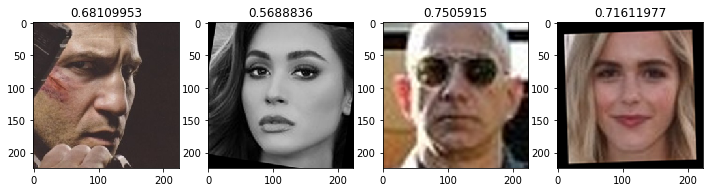

In [172]:
print("sample validation positive images ")
show_grid(sample_positive,vector_a=sample_anchor_emb,vector_b=sample_positive_emb)

sample validation positive images 


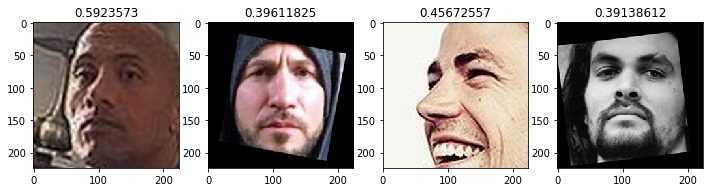

In [176]:
print("sample validation positive images ")
show_grid(sample_negative,vector_a=sample_anchor_emb,vector_b=sample_negative_emb)

In [126]:
# def img_convert(tensor):
#     image = tensor.cpu().clone().detach().numpy()
#     image = image.transpose(1, 2, 0)
#     image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
#     image = image.clip(0, 1)
#     return image

In [178]:
#creating visualization